# Section1/2 実装演習コード

簡単な迷路を解く問題を強化学習（方策勾配法）で実装し、方策なしでランダムに迷路を解いた結果と比較して強化学習（方策勾配法）の効果を確認する。

参考URL
https://book.mynavi.jp/manatee/detail/id=88297

diff_len_path_ave(iter: 1 )= 9.600000000000001
diff_len_path_ave(iter: 41 )= 43.397637244844006
diff_len_path_ave(iter: 81 )= 25.408800896500775
diff_len_path_ave(iter: 121 )= 6.252595406323026
diff_len_path_ave(iter: 161 )= 2.355161982450605
diff_len_path_ave(last(iter: 173 ))= 0.8333923394281579


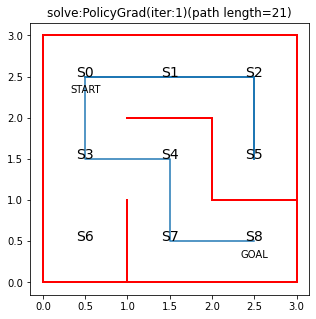

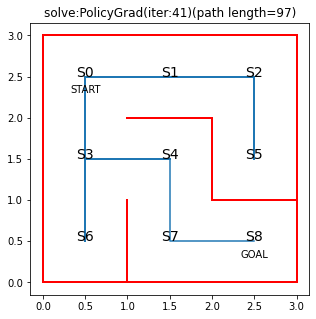

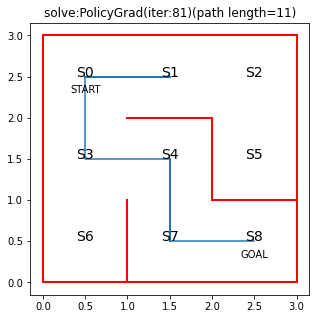

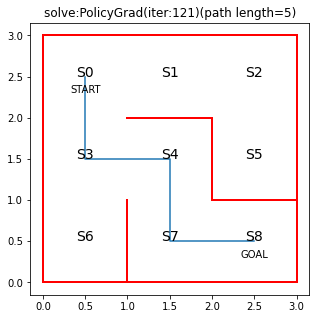

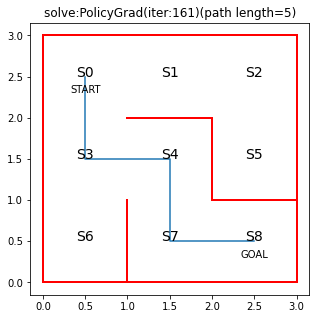

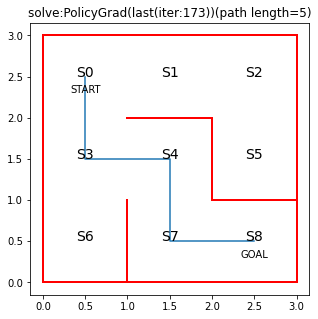

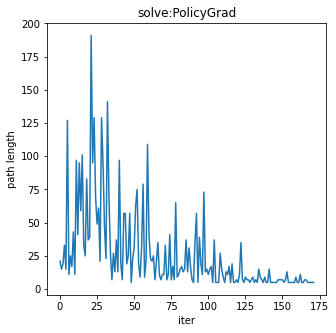

In [1]:
# 参考URL: https://book.mynavi.jp/manatee/detail/id=88297

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 迷路定義
#  [↑、→、↓、←]
MAZE_DEF = np.array(
    [[[np.nan, 1, 1, np.nan], [np.nan, 1, np.nan, 1], [np.nan, np.nan, 1, 1]], 
    [[1, 1, 1, np.nan], [np.nan, np.nan, 1, 1], [1, np.nan, np.nan, np.nan]], 
    [[1, np.nan, np.nan, np.nan], [1, 1, np.nan, np.nan], [np.nan, np.nan, np.nan, 1]]])

MAZE_INFO={ "W":MAZE_DEF.shape[1], 
            "H":MAZE_DEF.shape[0], 
            "S":0, 
            "G":MAZE_DEF.shape[0]*MAZE_DEF.shape[1]-1 }

# 方策パラメータthetaを行動方策piに変換: softmax
def softmax_convert_into_pi_from_theta(theta):
    # 行ける方向(≠np.nan)全てにソフトマックス関数で均等に確率を割り当てる
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    exp_theta = np.exp(1.0 * theta)

    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])

    # 行けない方向(=nan)には確率0を割り当て
    pi = np.nan_to_num(pi)  
    return pi

# 行動aと1step移動後の状態sを求める関数を定義
def get_action_and_next_s(pi, s, maze_w):
    direction = ["up", "right", "down", "left"]
    # pi[s,:]の確率に従って、directionが選択される
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - maze_w  # 上に移動
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 右に移動
    elif next_direction == "down":
        action = 2
        s_next = s + maze_w  # 下に移動
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 左に移動

    return [action, s_next]


# 迷路を解く関数の定義、状態と行動の履歴を出力
def goal_maze_ret_s_a(pi, state_s, state_g, maze_w):
    s = state_s  # スタート地点
    s_a_history = [[state_s, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        [action, next_s] = get_action_and_next_s(pi, s, maze_w)

        # 現在の状態（つまり一番最後なのでindex=-1）の行動を代入
        s_a_history[-1][1] = action

        # 次の状態を代入。行動はまだ分からないのでnanにしておく
        s_a_history.append([next_s, np.nan])

        if next_s == state_g:  # ゴール地点なら終了
            break
        else:
            s = next_s

    return s_a_history

# theta(各状態(位置)における行動(方向)回数)の更新
#   ゴールまで到達したパス(s_a_history)に含まれる方向(行動a)の回数を大きくする
def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 学習率
    T = len(s_a_history) - 1  # ゴールに至るパス長

    [stat_dim, act_dim] = theta.shape
    delta_theta = theta.copy()

    # ゴールまで到達したパスに含まれる行動＝価値大
    # パス長が小さいほど価値が大きい
    for s in range(0, stat_dim):
        for a in range(0, act_dim):
            if not(np.isnan(theta[s, a])):  # thetaがnanでない場合

                # 状態sで行動した総回数: N_s
                SA_s = [SA for SA in s_a_history if SA[0] == s]
                N_s = len(SA_s) 

                # 状態sで行動aをとった回数: N_sa
                SA_sa = [SA for SA in s_a_history if SA == [s, a]]
                N_sa = len(SA_sa)

                # {状態sで行動aをとる回数の実績(N_sa) + 予測値(N_s * π(s,a))} / パス長T
                delta_theta[s, a] = (N_sa + pi[s, a] * N_s) / T

    new_theta = theta + eta * delta_theta

    return new_theta


# 迷路、移動履歴の描画
def draw_maze_history(maze_def, maze_w, maze_h, state_s, state_g, state_hist, result_name):
    fig = plt.figure(facecolor="white", figsize=(5, 5))
    ax = plt.gca()
    for y in range(maze_h):
        for x in range(maze_w):
            state = y * maze_w + x

            # 状態を示す文字S0～S8を描く
            ax.text(float(x)+0.5, float(maze_h-y)-0.5, 
                    "S"+str(state), size=14, ha="center")
            if state == state_s:
                ax.text(float(x)+0.5, float(maze_h-y)-0.7, 'START', ha='center')
            elif state == state_g:
                ax.text(float(x)+0.5, float(maze_h-y)-0.7, 'GOAL', ha='center')

            # 壁描画
            for diridx, dir in enumerate(maze_def[y][x]):
                if np.isnan(dir):
                    # dir= [↑、→、↓、←]
                    if diridx == 0:
                        x0 = x
                        y0 = maze_h-y
                        x1 = x0 + 1
                        y1 = y0
                    elif diridx == 1:
                        x0 = x + 1
                        y0 = maze_h-y
                        x1 = x0
                        y1 = y0 - 1
                    elif diridx == 2:
                        x0 = x
                        y0 = maze_h-y-1
                        x1 = x0 + 1
                        y1 = y0
                    else:
                        x0 = x
                        y0 = maze_h-y
                        x1 = x0
                        y1 = y0 - 1

                    ax.plot([x0, x1], [y0, y1], color='red', linewidth=2)

    # 移動履歴の描画
    loc_history_x = []
    loc_history_y = []
    
    for state, _ in state_hist:
        loc_x = float(state % maze_w) + 0.5
        loc_y = float(maze_h - int(state / maze_w)) - 0.5
        loc_history_x.append(loc_x)
        loc_history_y.append(loc_y)

    str_title = result_name + "(path length=" + str(len(state_hist)) + ")"

    ax.set_title(str_title)
    ax.plot(loc_history_x, loc_history_y)
    return

# パス長変化の描画
def draw_len_path_history(len_hist, result_name):
    fig = plt.figure(facecolor="white", figsize=(5, 5))
    ax = plt.gca()

    x_iter = range(0, len(len_hist))
    ax.set_title(result_name)
    ax.set_xlabel("iter")
    ax.set_ylabel("path length")
    ax.plot(x_iter, len_hist)
    return

# 迷路を解く方式(0:ランダム、1:方策勾配法)
solve_method = 1

freq_draw = 40    # 可視化頻度
iter_th = 200     # 終了閾値: 繰り返し回数（閾値以上で強制打ち切り）

len_path_history = []

# 初期の方策π0を設定（動ける方向すべてに均等確率を与える）
theta_0 = MAZE_DEF.reshape(MAZE_INFO["W"] * MAZE_INFO["H"], 4)
pi_0 = softmax_convert_into_pi_from_theta(theta_0)

if solve_method == 0:
    # [迷路を解く方式＝ランダム]
    solve_method_str="Random"

    is_continue = True
    iter = 1
    while is_continue:  
        # 初期の方策π0で迷路を解く
        s_a_history = goal_maze_ret_s_a(pi_0, 
                        MAZE_INFO["S"], MAZE_INFO["G"], MAZE_INFO["W"])

        len_path = len(s_a_history)
        len_path_history.append(len_path)

        if iter > iter_th:
            is_continue = False

        # 今回の結果を可視化
        if (iter-1) % freq_draw == 0:
            draw_maze_history(MAZE_DEF, MAZE_INFO["W"], MAZE_INFO["H"], 
                MAZE_INFO["S"], MAZE_INFO["G"], s_a_history, 
                "solve:"+solve_method_str+"(iter:" + str(iter) + ")")
        iter += 1

elif solve_method == 1:
    # [迷路を解く方式＝方策勾配法]
    solve_method_str="PolicyGrad"

    diff_lenpath_stop_th = 1.0  # 学習終了閾値: パス長の変化（閾値以下になったら学習終了）

    theta = theta_0
    pi = pi_0

    len_path_prev = MAZE_INFO["W"] * MAZE_INFO["H"]
    diff_len_path_ave = len_path_prev

    is_continue = True
    iter = 1
    while is_continue:  
        # 方策πで迷路を解く
        s_a_history = goal_maze_ret_s_a(pi, 
                        MAZE_INFO["S"], MAZE_INFO["G"], MAZE_INFO["W"])  

        # 方策πを、ゴールまで到達したパスで更新
        #   ゴールまで到達したパスに含まれる方向の確率が大きくなるように更新
        new_theta = update_theta(theta, pi, s_a_history)
        new_pi = softmax_convert_into_pi_from_theta(new_theta)
 
        # 終了判定（ゴール到達パス長の変化小 or 回数大）
        len_path = len(s_a_history)
        len_path_history.append(len_path)

        # パス長変化（移動平均を取る）
        diff_len_path_ave = diff_len_path_ave * 0.8 
        diff_len_path_ave += abs(len_path - len_path_prev) * 0.2
        
        len_path_prev = len_path

        if (diff_len_path_ave < diff_lenpath_stop_th) or (iter > iter_th):
            is_continue = False
        else:
            theta = new_theta
            pi = new_pi

        # 今回の結果を可視化
        if (iter-1) % freq_draw == 0:
            print("diff_len_path_ave(iter:",str(iter),")=",diff_len_path_ave)
            draw_maze_history(MAZE_DEF, MAZE_INFO["W"], MAZE_INFO["H"], 
                MAZE_INFO["S"], MAZE_INFO["G"], 
                s_a_history, "solve:"+solve_method_str+"(iter:" + str(iter) + ")")

        iter += 1

    print("diff_len_path_ave(last(iter:",str(iter),"))=",diff_len_path_ave)

# 最終結果を可視化
draw_maze_history(MAZE_DEF, MAZE_INFO["W"], MAZE_INFO["H"], 
        MAZE_INFO["S"], MAZE_INFO["G"], 
        s_a_history, "solve:"+solve_method_str+"(last(iter:" + str(iter) + "))")

# パス長変化を可視化
draw_len_path_history(len_path_history, "solve:"+solve_method_str)
